In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/olist_geolocation_dataset.csv
/kaggle/input/product_category_name_translation.csv
/kaggle/input/olist_order_payments_dataset.csv
/kaggle/input/olist_sellers_dataset.csv
/kaggle/input/olist_order_reviews_dataset.csv
/kaggle/input/olist_customers_dataset.csv
/kaggle/input/olist_products_dataset.csv
/kaggle/input/olist_order_items_dataset.csv
/kaggle/input/olist_orders_dataset.csv


In [2]:
# Load Datasets
customers = pd.read_csv("../input/olist_customers_dataset.csv")
geolocation = pd.read_csv("../input/olist_geolocation_dataset.csv")
order_items = pd.read_csv("../input/olist_order_items_dataset.csv")
order_payments = pd.read_csv("../input/olist_order_payments_dataset.csv")
reviews = pd.read_csv("../input/olist_order_reviews_dataset.csv")
orders = pd.read_csv("../input/olist_orders_dataset.csv")
products = pd.read_csv("../input/olist_products_dataset.csv")
sellers = pd.read_csv("../input/olist_sellers_dataset.csv")
translations = pd.read_csv("../input/product_category_name_translation.csv")

In [3]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


# Data Exploration

First, lets see how many different products we are working with, how many categories and distribution per category. We will translate the names as a first step.

In [4]:
# Convert the translations to dictionary format
translations = translations.set_index('product_category_name')['product_category_name_english'].to_dict()

# translate the product category column in the products df to English
products['product_category_name'] = products['product_category_name'].map(translations)

In [5]:
#total number of unique products and categories
print("total unique products = " + str(len(products['product_id'])))
print("total unique categories = " + str(len(products['product_category_name'].unique())))

total unique products = 32951
total unique categories = 72


In [6]:
# Function to plot bar graphs
def plot_bar_graph(x,y,title):
    fig, axs = plt.subplots(1, 1, figsize=(20, 10), sharey=True)
    axs.bar(x, y)
    axs.set_title(title)
    plt.xticks(rotation =90)

    # data labels
    for i, v in enumerate(y):
        axs.text(i-.25, 
                  v+10, 
                  y[i], 
                  fontsize=8, 
                  #color=label_color_list[i]
                )
    return plt.show()

# Function to plot line graph
def plot_line_graph(x,y,title):
    fig, axs = plt.subplots(1, 1, figsize=(20, 10), sharey=True)
    axs.plot(x, y)
    axs.set_title(title)
    plt.xticks(rotation =90)

    # data labels
    for i, v in enumerate(y):
        axs.text(i-.25, 
                  v+10, 
                  y[i], 
                  fontsize=8, 
                  #color=label_color_list[i]
                )
    return plt.show()

# Function to plot bar graphs
def plot_scatter_graph(x,y,title):
    fig, axs = plt.subplots(1, 1, figsize=(20, 10), sharey=True)
    axs.scatter(x, y)
    axs.set_title(title)
    plt.xticks(rotation =90)

    # data labels
    for i, v in enumerate(y):
        axs.text(i-.25, 
                  v+10, 
                  y[i], 
                  fontsize=8, 
                  #color=label_color_list[i]
                )
    return plt.show()

In [7]:
# check for missing values
# since we are only concerned about these two columns we will check only these two:
print("Missing Values = " + str(products[["product_id","product_category_name"]].isna().values.sum()))

products[["product_id","product_category_name"]].isna().any(axis =1)

# drop the products with missing category names
products = products.dropna(subset=['product_id', 'product_category_name'])
products.head()

Missing Values = 623


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0


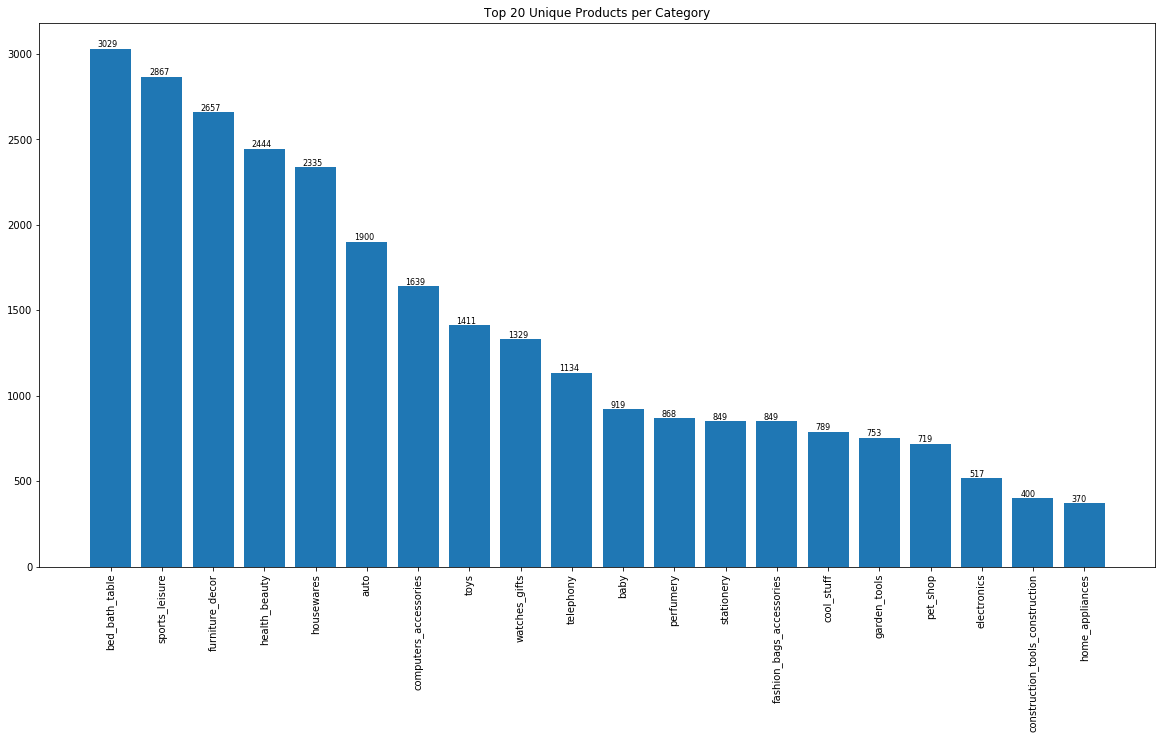

In [8]:
# distribution of unique products per category
product_category = products[['product_id','product_category_name']] \
.groupby('product_category_name')['product_id'] \
.count()\
.sort_values(ascending=False) \
.to_dict()

product_category_names = list(product_category.keys())[:20]
product_category_values = list(product_category.values())[:20]

plot_bar_graph(product_category_names,product_category_values,"Top 20 Unique Products per Category")

In [9]:
# Orders per Product
# Join the two datasets
order_products = pd.merge(order_items, products, left_on = 'product_id', right_on = 'product_id')

# plot the data
order_products[['product_category_name','order_id']]

,product_category_name,order_id
0,cool_stuff,00010242fe8c5a6d1ba2dd792cb16214
1,cool_stuff,130898c0987d1801452a8ed92a670612
2,cool_stuff,532ed5e14e24ae1f0d735b91524b98b9
3,cool_stuff,6f8c31653edb8c83e1a739408b5ff750
4,cool_stuff,7d19f4ef4d04461989632411b7e588b9
...,...,...
111018,garden_tools,ffebd80e3291e811c308365936897efd
111019,furniture_decor,ffee31fb4b5e35c9123608015637c495
111020,watches_gifts,fff7c4452f050315db1b3f24d9df5fcd
111021,sports_leisure,fffa82886406ccf10c7b4e35c4ff2788


In [10]:
# check for missing values
# since we are only concerned about these two columns we will check only these two:
print("Missing Values = " + str(order_products[["product_category_name","order_id"]].isna().values.sum()))

order_products[order_products[["product_category_name","order_id"]].isna().any(axis =1)]

# drop the orders with missing category names
order_products = order_products.dropna(subset=["product_category_name","order_id"])


Missing Values = 0


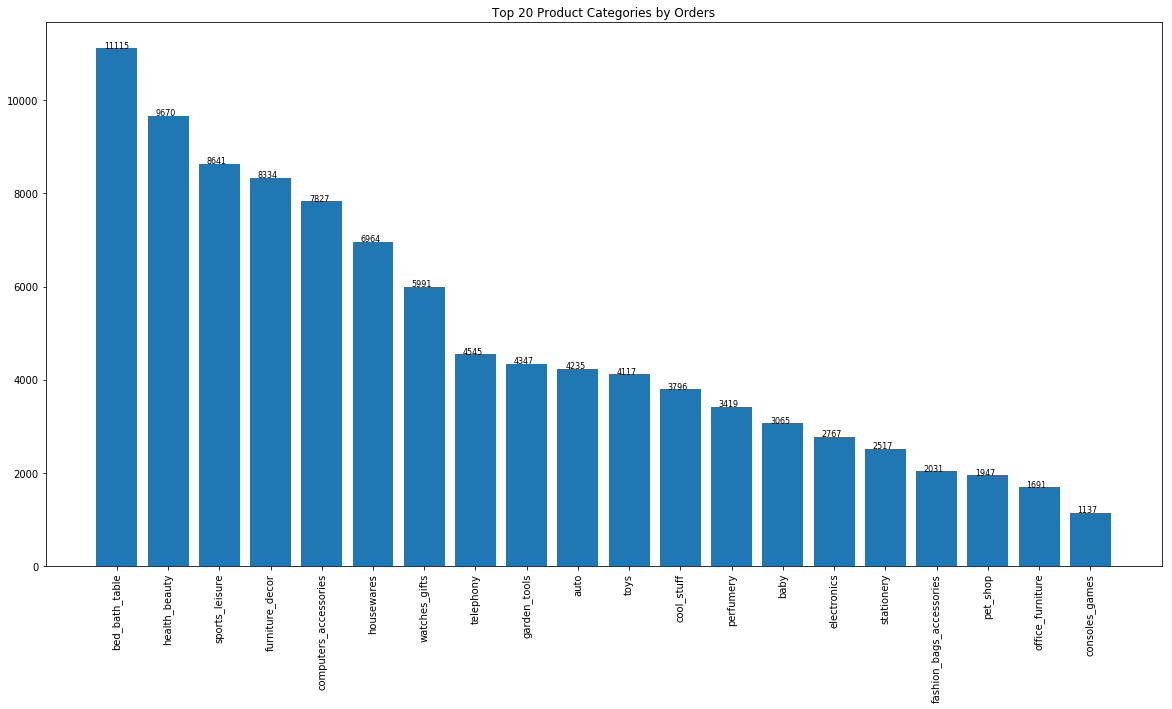

In [11]:
# plot the data
order_products_dict = order_products[['product_category_name','order_id']] \
.groupby('product_category_name')['order_id'] \
.count()\
.sort_values(ascending=False) \
.to_dict()


order_product_names = list(order_products_dict.keys())[:20]
order_product_values = list(order_products_dict.values())[:20]

plot_bar_graph(order_product_names,order_product_values,"Top 20 Product Categories by Orders")

In [12]:
# Check how many orders have more than one product
print("Total Orders: " + str(len(order_items['order_id'].unique())))
print("Total Orders with 2 or more items: " + str(len(order_items[order_items['order_item_id'] == 2])))

Total Orders: 98666
Total Orders with 2 or more items: 9803


In [13]:
order_products.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0


# Association Mining

We will perform association mining on two levels, category wise and then product wise within those categories. This is because there are too many different products for us to perform association mining across all products.

## Category Association

### Data Preprocessing

In [14]:
# Transforming the data into the correct format

basket = order_products.groupby(['order_id','product_category_name'])['order_item_id']\
                                    .sum() \
                                    .unstack() \
                                    .reset_index() \
                                    .fillna(0) \
                                    .set_index('order_id')

# recode all multiple purchases to 1
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1: 
        return 1
basket_sets = basket.applymap(encode_units)
basket_sets.head()

product_category_name,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
order_id,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00018f77f2f0320c557190d7a144bdd3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000229ec398224ef6ca0657da4fc703e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00024acbcdf0a6daa1e931b038114c75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00042b26cf59d7ce69dfabb4e55b4fd9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# remove all orders with less than 2 different categories
basket_sets = basket_sets[basket_sets.sum(axis = 1) > 1]
basket_sets[basket_sets.sum(axis = 1) > 1]

product_category_name,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
order_id,,,,,,,,,,,,,,,,,,,,,
002f98c0f7efd42638ed6100ca699b42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
005d9a5423d47281ac463a968b3936fb,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
014405982914c2cde2796ddcf0b8703d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
01b1a7fdae9ad1837d6ab861705a1fa5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
01cce1175ac3c4a450e3a0f856d02734,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe64170e936bc5f6a6a41def260984b9,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
fe678293ea3bb6607a15b2e320e91722,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
ff00a56fe9475a175cd651d77c707a09,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Analysis

In [16]:
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames = True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.1)

df_results1 = pd.DataFrame(rules)
df_results1.sort_values(["confidence"],ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11,(home_confort),(bed_bath_table),0.068871,0.272727,0.059229,0.860000,3.153333,0.040446,5.194805
16,(construction_tools_lights),(furniture_decor),0.024793,0.279614,0.015152,0.611111,2.185550,0.008219,1.852420
18,(home_construction),(furniture_decor),0.035813,0.279614,0.017906,0.500000,1.788177,0.007893,1.440771
24,(perfumery),(health_beauty),0.035813,0.096419,0.016529,0.461538,4.786813,0.013076,1.678079
4,(toys),(baby),0.068871,0.128099,0.026171,0.380000,2.966452,0.017349,1.406292
8,(bed_bath_table),(furniture_decor),0.272727,0.279614,0.096419,0.353535,1.264368,0.020160,1.114347
7,(furniture_decor),(bed_bath_table),0.279614,0.272727,0.096419,0.344828,1.264368,0.020160,1.110048
1,(cool_stuff),(baby),0.089532,0.128099,0.027548,0.307692,2.401985,0.016079,1.259412
20,(housewares),(furniture_decor),0.140496,0.279614,0.033058,0.235294,0.841495,-0.006227,0.942043
17,(garden_tools),(furniture_decor),0.100551,0.279614,0.023416,0.232877,0.832850,-0.004700,0.939074


## Product Association

We are going to focus on the two categories that are frequently purchased together.

### Data Preprocessing

In [17]:
# Transforming the data into the correct format

basket_product = order_products[(order_products['product_category_name'] == "home_confort") | 
                               (order_products['product_category_name'] == "bed_bath_table")]\
                                    .groupby(['order_id','product_id'])['order_item_id']\
                                    .sum() \
                                    .unstack() \
                                    .reset_index() \
                                    .fillna(0) \
                                    .set_index('order_id')


basket_product_sets = basket_product.applymap(encode_units)
basket_product_sets.head()

product_id,0009406fd7479715e4bef61dd91f2462,001b237c0e9bb435f2e54071129237e9,001c5d71ac6ad696d22315953758fa04,0085dddda27567189f1dfd1eda7c286e,008686d56f4c85b987a4c24a286834c1,00905d58c87afcbce21420b3712cacaa,00be617b58175bf207fd35910d5097a4,00d2fa6f2a87633084c8e0400d41a65a,013ee64977aaa6b2b25475095162e0e9,0152f69b6cf919bcdaf117aa8c43e5a2,...,fe6f03cedd96bcbc5c8726c5963fd35c,fe95eb948375116da759c8ef60295001,fec565c4e3ad965c73fb1a21bb809257,fedaaeb6d54cd9772c003ec97ce92ff7,ff2c1ec09b1bb340e84f0d6b21cc7dbb,ff50a7795bf14586aeb06610fae49095,ff7aa48b8bc68495866b40c4010d58c9,ff7c7524d5f9a8386ab27088ec03c1fb,ff96895c6b1d31f34b2d82f86670fa85,ffe8083298f95571b4a66bfbc1c05524
order_id,,,,,,,,,,,,,,,,,,,,,
0006ec9db01a64e59a68b2c340bf65a7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000e63d38ae8c00bbcb5a30573b99628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00169e31ef4b29deaae414f9a5e95929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001c85b5f68d2be0cb0797afc9e8ce9a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001dbc16dc51075e987543d23a0507c7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# remove all orders with less than 2 different categories
basket_product_sets = basket_product_sets[basket_product_sets.sum(axis = 1) > 1]
basket_product_sets.head()

product_id,0009406fd7479715e4bef61dd91f2462,001b237c0e9bb435f2e54071129237e9,001c5d71ac6ad696d22315953758fa04,0085dddda27567189f1dfd1eda7c286e,008686d56f4c85b987a4c24a286834c1,00905d58c87afcbce21420b3712cacaa,00be617b58175bf207fd35910d5097a4,00d2fa6f2a87633084c8e0400d41a65a,013ee64977aaa6b2b25475095162e0e9,0152f69b6cf919bcdaf117aa8c43e5a2,...,fe6f03cedd96bcbc5c8726c5963fd35c,fe95eb948375116da759c8ef60295001,fec565c4e3ad965c73fb1a21bb809257,fedaaeb6d54cd9772c003ec97ce92ff7,ff2c1ec09b1bb340e84f0d6b21cc7dbb,ff50a7795bf14586aeb06610fae49095,ff7aa48b8bc68495866b40c4010d58c9,ff7c7524d5f9a8386ab27088ec03c1fb,ff96895c6b1d31f34b2d82f86670fa85,ffe8083298f95571b4a66bfbc1c05524
order_id,,,,,,,,,,,,,,,,,,,,,
00337fe25a3780b3424d9ad7c5a4b35e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0132451f29a10b66a5cf1bacc85f9afe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
013a98b3a668bcef05b98898177f6923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0179a3003c894f1dd3b1ddda5d1f8a12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
017dcb6892d4469a13dee34f241f8c4e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Analysis

In [19]:
frequent_itemsets_product = apriori(basket_product_sets, min_support=0.005, use_colnames = True)
rules_product = association_rules(frequent_itemsets_product, metric='confidence', min_threshold=0.5)

pd.DataFrame(rules_product).sort_values(["confidence"],ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fb783e3e545937820b57fe539b2c5a6c),(0fa81e7123fd0ebe03adbbe99d912827),0.006024,0.013554,0.006024,1.000000,73.777778,0.005942,inf
1,(35afc973633aaeb6b877ff57b2793310),(99a4788cb24856965c36a24e339b6058),0.054217,0.072289,0.043675,0.805556,11.143519,0.039755,4.771084
5,(64fb265487de2238627ce43fe8a67efc),(84f456958365164420cfc80fbe4c7fab),0.007530,0.010542,0.006024,0.800000,75.885714,0.005945,4.947289
3,(4d0ec1e9b95fb62f9a1fbe21808bf3b1),(9ad75bd7267e5c724cb42c71ac56ca72),0.013554,0.019578,0.009036,0.666667,34.051282,0.008771,2.941265
7,(ad0a798e7941f3a5a2fb8139cb62ad78),(946344697156947d846d27fe0d503033),0.013554,0.015060,0.009036,0.666667,44.266667,0.008832,2.954819
2,(99a4788cb24856965c36a24e339b6058),(35afc973633aaeb6b877ff57b2793310),0.072289,0.054217,0.043675,0.604167,11.143519,0.039755,2.389347
6,(946344697156947d846d27fe0d503033),(ad0a798e7941f3a5a2fb8139cb62ad78),0.015060,0.013554,0.009036,0.600000,44.266667,0.008832,2.466114
8,(f2e53dd1670f3c376518263b3f71424d),(99a4788cb24856965c36a24e339b6058),0.015060,0.072289,0.009036,0.600000,8.300000,0.007947,2.319277
4,(84f456958365164420cfc80fbe4c7fab),(64fb265487de2238627ce43fe8a67efc),0.010542,0.007530,0.006024,0.571429,75.885714,0.005945,2.315763
9,(c211ff3068fcd2f8898192976d8b3a32),(f4d705aa95ccca448e5b0deb6e5290ba),0.010542,0.010542,0.006024,0.571429,54.204082,0.005913,2.308735
